In [1]:
import sys
import os
# caution: path[0] is reserved for script path (or '' in REPL)
os.environ['MUJOCO_PY_MUJOCO_PATH']='/scratch_net/biwidl216/rl_course_14/.mujoco/mujoco210'

#add DiffuseDrive to path. Dont know why, but else diffuser folder is not seen.
# os.environ['PYTHONPATH'] = str(os.environ['PYTHONPATH']) + '~/DiffuseDrive'

import diffuser.utils as utils
import torch
import wandb
# logging.basicConfig(filename='logs/training.log', encoding='utf-8', level=logging.INFO)
from logger_module import logger
from tqdm import tqdm

2023-06-05 16:03:34,115 - INFO - MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.
2023-06-05 16:03:34,125 - INFO - Successfully imported OpenGL backend: glfw
2023-06-05 16:03:34,179 - INFO - MuJoCo library version is: 2.3.5
pybullet build time: May 20 2022 19:44:17
/scratch_net/biwidl216/rl_course_14/conda_envs/diffuser_planning/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_config = utils.Config(
    'datasets.CollectedSequenceDataset',
    savepath='dataset_config.pkl',
    env='carla-expert',
    horizon=12,
    normalizer='CDFNormalizer',
    preprocess_fns=[],
    use_padding=True,
    max_path_length=10,
    include_returns=True,
    returns_scale=400,
    discount=0.99,
    termination_penalty=-100,
    past_image_cond = False, 
    is_valid=True,
    using_cmd=True,
)

dataset = dataset_config()

[ utils/config ] Imported diffuser.datasets:CollectedSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.CollectedSequenceDataset'>
    discount: 0.99
    env: carla-expert
    horizon: 12
    include_returns: True
    is_valid: True
    max_path_length: 10
    normalizer: CDFNormalizer
    past_image_cond: False
    preprocess_fns: []
    returns_scale: 400
    termination_penalty: -100
    use_padding: True
    using_cmd: True

[ utils/config ] Saved config to: dataset_config.pkl



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import json

In [4]:
next(iter(dataset))[2]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
def transform_2d_points(xyz, r1, t1_x, t1_y, r2, t2_x, t2_y):
        """
        Build a rotation matrix and take the dot product.
        """
        # z value to 1 for rotation
        xy1 = xyz.copy()
        xy1[:, 2] = 1
        xy1_front = xy1.copy()
        xy1_front[:,0] += 1.0

        c, s = np.cos(r1), np.sin(r1)
        r1_to_world = np.matrix([[c, s, t1_x], [-s, c, t1_y], [0, 0, 1]])

        # np.dot converts to a matrix, so we explicitly change it back to an array
        world = np.asarray(r1_to_world @ xy1.T)
        world_front = np.asarray(r1_to_world @ xy1_front.T)

        c, s = np.cos(r2), np.sin(r2)
        r2_to_world = np.matrix([[c, s, t2_x], [-s, c, t2_y], [0, 0, 1]])
        world_to_r2 = np.linalg.inv(r2_to_world)

        out = np.asarray(world_to_r2 @ world).T
        out_front = np.asarray(world_to_r2 @ world_front).T
        # reset z-coordinate
        out[:, 2] = np.arctan2(out_front[:,1]-out[:,1], out_front[:,0] - out[:,0])

        return out

##here gps:=ego wp
def convert_gps_to_ego(gps_waypoints, current_gps_waypoint):
        ego_waypoint = [None] * len(gps_waypoints)
        for t in range(len(gps_waypoints)):
            if not isinstance(gps_waypoints[t], np.ndarray):
                break

            ego_waypoint[t] = transform_2d_points(
                np.zeros((1,3)),
                np.pi / 2 - gps_waypoints[t][2],
                    -gps_waypoints[t][0],
                    -gps_waypoints[t][1],
                    np.pi / 2 - current_gps_waypoint[2],
                    -current_gps_waypoint[0],
                    -current_gps_waypoint[1],
            )
        return ego_waypoint

In [ ]:
## birdview size=(400,400), ego vihecle is centered
def vis_with_bev(bev_img, traj, color):
    ## Set up figure
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (6,6)
    margin_max = 400  #sample_t.max()+1
    margin_min = 0   #sample_t.min()-1
    norm = plt.Normalize(margin_min, margin_max)
    ax.set_xlim(margin_min, margin_max)
    ax.set_ylim(margin_min, margin_max)
    img = Image.fromarray(bev_img)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    img = img.resize((500,500))
    
    ax.imshow(img, extent=[0,500,0,500])

    ## for color display
    length = len(traj)*2
    for i, poses in enumerate(traj):
        dx = np.cos(poses[-1]-np.pi/2)/5
        dy = np.sin(poses[-1]-np.pi/2)/5
        # ,alpha=0.5+i/length
        #waypoint = np.around(poses*5+20*10).astype(int)
        waypoint = poses*5+250
        #pos_0 = (poses[0]+offset)
        ax.scatter(waypoint[0], waypoint[1],s=10, color=color, alpha=0.5+i/length)
        if i == 11:
            ax.arrow(waypoint[0], waypoint[1], dx, dy, head_width=7, color='blue',alpha=0.5+i/length)
        if i== 3:
            ax.text(waypoint[0]-0.05, waypoint[1]+0.05, 'c', fontsize=10)
        #ax.text(poses[0]-0.05+offset, poses[1]+0.05+offset, i, fontsize=15)
    ## In actual use: plt.savefig
    plt.show()


In [ ]:
i=0
samples = []
for data in dataset:
    sample_t, _, birdview = data
    if  25<=i<=35 and i%5==0:
        print(i)
        #img = Image.open("../birdview/%04d.jpg"%(i+3))
        vis_with_bev(birdview, sample_t, "yellow")
        #print(sample_t)
        #samples.append(sample_t)
        time.sleep(1)
    i+=1
    if i==35: 
        break
#img = Image.open("../birdview/0058.jpg")
#vis_with_bev(img, sample_t, "purple")

In [ ]:
i=150
img=Image.open("../birdview/%04d.jpg"%i)
path = "../sample_test/weather-0/data/routes_town02_long_w0_04_16_17_24_03/measurements/"

sample_x = []
sample_y = []
sample_z = []
while i<=180:
    data = json.load(open(path+"%04d.json"%i))
    sample_x.append(data.get("gps_x"))
    sample_y.append(data.get("gps_y"))
    sample_z.append(data.get("theta"))
    i+=1

In [ ]:
sample_x_a = np.array(sample_x)
sample_y_a = np.array(sample_y)
sample_z_a = np.array(sample_z)
samples = np.hstack([sample_x_a[:,np.newaxis], sample_y_a[:,np.newaxis], sample_z_a[:,np.newaxis]])

In [ ]:
ego_samples = convert_gps_to_ego(samples, samples[0])
ego_samples = np.array(ego_samples).reshape((-1,3))

In [ ]:
#samples = np.concatenate(sample_x_a, sample_y_a)

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (6,6)
margin_max = 450  #sample_t.max()+1
margin_min = 50   #sample_t.min()-1
norm = plt.Normalize(margin_min, margin_max)
ax.set_xlim(margin_min, margin_max)
ax.set_ylim(margin_min, margin_max)
img1 = img.transpose(Image.FLIP_TOP_BOTTOM)
img1 = img1.resize((500,500))
ax.imshow(img1, extent=[0,500,0,500])

## for color display
length = len(sample_x)*2

for i, poses in enumerate(ego_samples):
    dx = np.cos(poses[-1]-np.pi/2)/5
    dy = np.sin(poses[-1]-np.pi/2)/5
    # ,alpha=0.5+i/length
    waypoint = poses*5+250
    #pos_0 = (poses[0]+offset)
    ax.scatter(waypoint[0], waypoint[1],s=10, color='red', alpha=0.5+i/length)
    if i == 11:
        ax.arrow(waypoint[0], waypoint[1], dx, dy, head_width=2, color='blue',alpha=0.5+i/length)
    if i== 0:
        ax.text(waypoint[0]-0.05, waypoint[1]+0.05, i, fontsize=10)
        print(waypoint[0])
        print(waypoint[1])
    #ax.text(poses[0]-0.05+offset, poses[1]+0.05+offset, i, fontsize=15)
## In actual use: plt.savefig
plt.show()

In [ ]:
traj_samples = []
i=1
traj_samples.append(samples[0])
traj_samples.append(convert_ego_to_gps(samples[0], np.array([-130.995,
193.721, 6.27191781997])))

In [ ]:
traj_samples[0]

In [ ]:
traj_samples[1]

In [ ]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [ ]:
dataloader = cycle(torch.utils.data.DataLoader(
    dataset, batch_size=1, num_workers=0, pin_memory=True, shuffle = False
))

In [ ]:
tmp = next(dataloader)


In [ ]:
print(tmp[0])
print(tmp[0][0,:,:-1]) # x and y coordinates

In [ ]:
all_zeros_count = 0
for i, data in enumerate(tqdm(dataloader)):
    # print(i)
    # print(data[0].max())
    # print(data[0])
    if data[0][0,:,:-1].max() <= 1e-6:
        all_zeros_count += 1
    
    if i > 50000:
        break

In [ ]:
print(all_zeros_count)
print(i)

In [ ]:
print(all_zeros_count/(i+1))

# Load trained model and generate waypoints

In [5]:
class Parser(utils.Parser):
    dataset: str = 'carla-expert'
    config: str = 'config.carla'

args = Parser().parse_args('diffusion')

dataset_config = utils.Config(
    args.loader,
    savepath='dataset_config.pkl',
    env=args.dataset,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
    include_returns=args.include_returns,
    returns_scale=args.returns_scale,
    discount=args.discount,
    termination_penalty=args.termination_penalty,
    past_image_cond = args.past_image_cond,
    waypoints_normalization = args.waypoints_normalization,
    using_cmd = args.using_cmd,
)

## TODO from Minxuan: need check from Jacopo if it works
valid_dataset_config = utils.Config(
    args.loader,
    savepath='tmp',
    env=args.dataset,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
    include_returns=args.include_returns,
    returns_scale=args.returns_scale,
    discount=args.discount,
    termination_penalty=args.termination_penalty,
    past_image_cond = args.past_image_cond,
    waypoints_normalization = args.waypoints_normalization,
    is_valid = True,
    using_cmd = args.using_cmd,
)

dataset = dataset_config()
valid_dataset = valid_dataset_config()
# renderer = render_config()
renderer = None
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim

[ utils/setup ] Reading config: config.carla:carla_expert
[ utils/setup ] Not using overrides | config: config.carla | dataset: carla_expert
[ utils/setup ] Setting seed: 100
[ utils/setup ] Setting exp_name to: diffusion/defaults_H12_T200_d1
[ utils/setup ] Saved args to logs/carla-expert/diffusion/defaults_H12_T200_d1/args.json
[ utils/config ] Imported diffuser.datasets:CollectedSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.CollectedSequenceDataset'>
    discount: 1
    env: carla-expert
    horizon: 12
    include_returns: True
    max_path_length: 10
    normalizer: CDFNormalizer
    past_image_cond: True
    preprocess_fns: []
    returns_scale: 400.0
    termination_penalty: -100
    use_padding: True
    using_cmd: True
    waypoints_normalization: full_space

[ utils/config ] Saved config to: dataset_config.pkl

[ utils/config ] Imported diffuser.datasets:CollectedSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.Collecte

In [6]:
model_config = utils.Config(
    args.model,
    image_backbone = args.image_backbone,
    savepath='model_config.pkl',
    horizon=args.horizon,
    transition_dim=observation_dim + action_dim,
    cond_dim=observation_dim,
    dim_mults=args.dim_mults,
    returns_condition=args.returns_condition,
    dim=args.dim,
    condition_dropout=args.condition_dropout,
    calc_energy=args.calc_energy,
    device=args.device,
    past_image_cond = args.past_image_cond,
    image_backbone_freeze = args.image_backbone_freeze,
    using_cmd = args.using_cmd,
    # attention??
)

diffusion_config = utils.Config(
    args.diffusion,
    savepath='diffusion_config.pkl',
    horizon=args.horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=args.n_diffusion_steps,
    loss_type=args.loss_type,
    clip_denoised=args.clip_denoised,
    predict_epsilon=args.predict_epsilon,
    hidden_dim=args.hidden_dim,
    ar_inv=args.ar_inv,
    train_only_inv=args.train_only_inv,
    ## loss weighting
    action_weight=args.action_weight,
    loss_weights=args.loss_weights,
    loss_discount=args.loss_discount,
    returns_condition=args.returns_condition,
    condition_guidance_w=args.condition_guidance_w,
    device=args.device,
)

trainer_config = utils.Config(
    utils.Trainer,
    savepath='trainer_config.pkl',
    train_batch_size=args.batch_size,
    train_lr=args.learning_rate,
    lr_decay=args.lr_decay,
    lr_decay_steps=args.lr_decay_steps,
    gradient_accumulate_every=args.gradient_accumulate_every,
    ema_decay=args.ema_decay,
    sample_freq=args.sample_freq,
    save_freq=args.save_freq,
    log_freq=args.log_freq,
    label_freq=int(args.n_train_steps // args.n_saves),
    save_parallel=args.save_parallel,
    bucket=args.bucket,
    n_reference=args.n_reference,
    train_device=args.device,
    save_checkpoints=args.save_checkpoints,
    save_final=args.save_final,
    final_model_path = args.final_model_path,
)

[ utils/config ] Imported diffuser.models:TemporalUnetCarla

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnetCarla'>
    calc_energy: False
    cond_dim: 3
    condition_dropout: 0.1
    dim: 128
    dim_mults: (1, 4, 8)
    horizon: 12
    image_backbone: lraspp_mobilenet
    image_backbone_freeze: True
    past_image_cond: True
    returns_condition: True
    transition_dim: 3
    using_cmd: True

[ utils/config ] Saved config to: model_config.pkl

[ utils/config ] Imported diffuser.models:GaussianInvDynDiffusionCarla

[utils/config ] Config: <class 'diffuser.models.diffusion.GaussianInvDynDiffusionCarla'>
    action_dim: 0
    action_weight: 10
    ar_inv: False
    clip_denoised: True
    condition_guidance_w: 1.2
    hidden_dim: 256
    horizon: 12
    loss_discount: 1
    loss_type: l2
    loss_weights: None
    n_timesteps: 200
    observation_dim: 3
    predict_epsilon: True
    returns_condition: True
    train_only_inv: False

[ utils/config ] Saved confi

In [7]:
model = model_config()

diffusion = diffusion_config(model)

wandb_run = wandb.init(project="diffuse_drive", entity="mleong", config=args)
trainer = trainer_config(diffusion, dataset, valid_dataset, renderer, wandb_run)

[ models/temporal ] Channel dimensions: [(3, 128), (128, 512), (512, 1024)]
[(3, 128), (128, 512), (512, 1024)]


/scratch_net/biwidl216/rl_course_14/conda_envs/diffuser_planning/lib/python3.8/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/scratch_net/biwidl216/rl_course_14/conda_envs/diffuser_planning/lib/python3.8/site-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: leongkhing96 (mleong). Use `wandb login --relogin` to force relogin
/scratch_net/biwidl216/rl_course_14/conda_envs/diffuser_planning/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:47: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [8]:
print(model.past_image_cond)

True


In [9]:
if args.using_cmd and args.past_image_cond:
    trainer.load("/scratch_net/biwidl216/rl_course_14/project/our_approach/DiffuseDriveClean/trained_models/step_model_ema_cmd.pt")
elif args.past_image_cond:
    trainer.load("/scratch_net/biwidl216/rl_course_14/project/our_approach/DiffuseDriveClean/trained_models/step_model_ema.pt")
else:
    print("load unconditioned model")
    trainer.load("/scratch_net/biwidl216/rl_course_14/project/our_approach/DiffuseDriveClean/trained_models/step_model_ema_unconditioned.pt")

In [15]:
trainer.visualize_bev(batch_size=40, n_samples=10)

/scratch_net/biwidl216/rl_course_14/conda_envs/diffuser_planning/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


KeyboardInterrupt: 

In [235]:
for i in range(10):
    batch = trainer.dataloader_vis.__next__()

In [236]:
from torchvision.models.segmentation import lraspp_mobilenet_v3_large

In [237]:
image_seg = lraspp_mobilenet_v3_large(weights='LRASPP_MobileNet_V3_Large_Weights.DEFAULT')

In [253]:
import PIL
# print(batch.keys())
from torchvision.models.segmentation.lraspp import LRASPP_MobileNet_V3_Large_Weights
image_list = [batch.images[0][0], batch.images[0][1], batch.images[0][2], batch.images[0][3]]
preprocess = LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
# input_image = preprocess(batch.images[0])
input_image = batch.images[0]
seg_output = image_seg(input_image)


In [254]:
print(seg_output['out'].shape)
print(seg_output['out'].argmax(axis=1)[0])

import torchvision.transforms.functional as F
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

torch.Size([4, 21, 128, 128])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


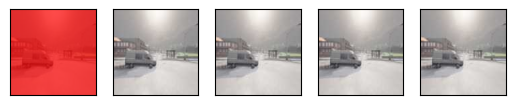

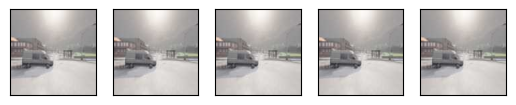

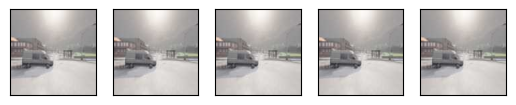

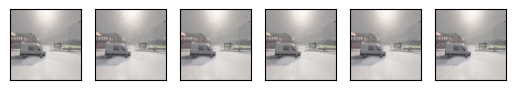

In [255]:
from torchvision.utils import draw_segmentation_masks

normalized_masks = torch.nn.functional.softmax(seg_output['out'], dim=1)

masks = [None] * seg_output['out'].shape[1]
for i in range(seg_output['out'].shape[1]):
    masks[i] = (seg_output['out'].argmax(axis=1)[0] == i)

image_with_masks = [
    draw_segmentation_masks(input_image.to(torch.uint8)[0], masks=masks[i], alpha=0.7, colors=(255,0,0))
    for i in range(seg_output['out'].shape[1])
]
show(image_with_masks[0:5])
show(image_with_masks[5:10])
show(image_with_masks[10:15])
show(image_with_masks[15:])